# Saudi League Analysis
# Part 2: Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");
pd.set_option('display.max_rows', None);
sns.set_context("talk");
%matplotlib inline

# ================================================

from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor


# Content:
## 1- Load Data
## 2- Features Selection
- Correlation Based
- Recursive Feature Elimination

## 3- Models Selection
- Check Different Models
- Hyper-parameters Tuning

## 4- Model Evaluation

## 1- Load Data

In [2]:
data = pd.read_csv('cleaned.csv')
data.head()

,year,Rk,Squad,MP,W,D,L,GF,GA,GDiff,...,Attendance,Pk,Min,Age,n_FW,n_MF,n_DF,n_GK,n_S,n_nS
0,2019,1,Al-Hilal,30,22,6,2,74,26,48,...,10683,12,29691,27,3,13,9,2,20,7
1,2018,1,Al-Nassr,30,22,4,4,69,27,42,...,16408,8,29648,26,4,13,11,3,22,9
2,2018,2,Al-Hilal,30,21,6,3,66,33,33,...,19551,12,29634,27,5,14,9,2,19,11
3,2016,1,Al-Hilal,26,21,3,2,63,16,47,...,15387,5,25668,25,4,17,9,1,25,6
4,2014,1,Al-Nassr,26,20,4,2,62,20,42,...,19579,7,25621,26,6,11,9,2,22,6


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        54 non-null     int64 
 1   Rk          54 non-null     int64 
 2   Squad       54 non-null     object
 3   MP          54 non-null     int64 
 4   W           54 non-null     int64 
 5   D           54 non-null     int64 
 6   L           54 non-null     int64 
 7   GF          54 non-null     int64 
 8   GA          54 non-null     int64 
 9   GDiff       54 non-null     int64 
 10  Pts         54 non-null     int64 
 11  Attendance  54 non-null     int64 
 12  Pk          54 non-null     int64 
 13  Min         54 non-null     int64 
 14  Age         54 non-null     int64 
 15  n_FW        54 non-null     int64 
 16  n_MF        54 non-null     int64 
 17  n_DF        54 non-null     int64 
 18  n_GK        54 non-null     int64 
 19  n_S         54 non-null     int64 
 20  n_nS        

## 2- Features Selection

In [4]:
# Function to Remove Corrlated Featuers
def cor_featuers(data, threshold):
    cor_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)) :
        for j in range(i):
            if abs(corrmat.iloc[i,j]) > threshold:
                colname = corrmat.columns[i]
                cor_col.add(colname)
    
    return cor_col

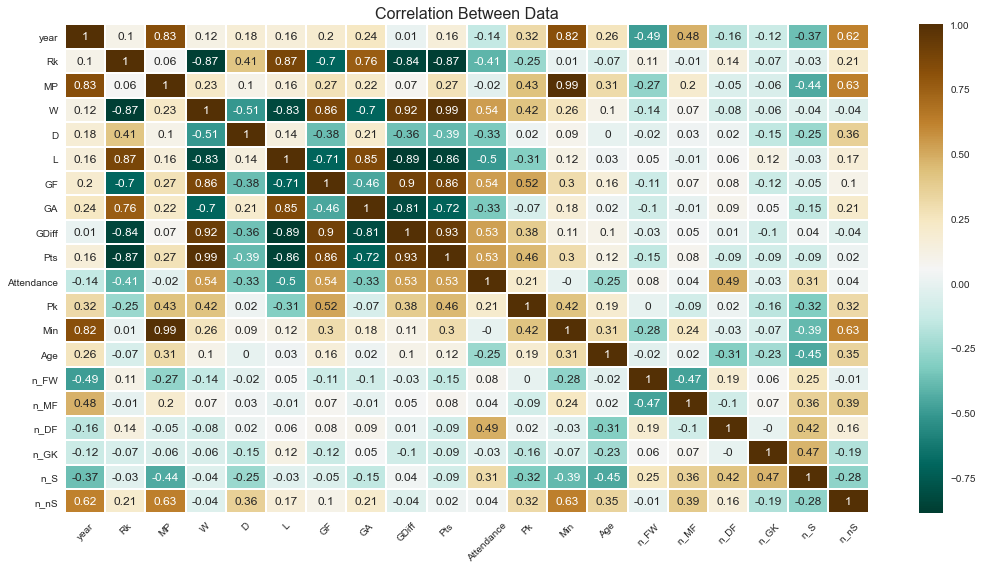

In [5]:
# Plot the correlation
plt.figure(figsize=(18,9))
sns.heatmap(data.corr().round(2), linewidths=1, annot=True, cmap='BrBG_r');
plt.title('Correlation Between Data', fontsize=16);
plt.xticks(rotation=45);

### 1- Features Selection

#### A- Features Selection Based on Correlation

In [6]:
# Filter Features based on a threshold
th = 0.75

print('Number of removed featurs:' ,len(cor_featuers(data, th)))
print('Featuers to be removed ',(cor_featuers(data,th)))

Number of removed featurs: 8
Featuers to be removed  {'W', 'Pts', 'L', 'MP', 'Min', 'GF', 'GA', 'GDiff'}


In [7]:
# Add to the removed features Attendance since it is unknown until the end of the season
#                             and year because it has no known effects on teams points

f_to_drop = ['MP', 'GF', 'GDiff', 'L', 'GA', 'Min', 'W', 'Pts','Pk', 'D', 'Rk','Attendance', 'year']
X = data.drop( f_to_drop , axis=1)
y = data.Pts

In [8]:
# Remained features:
print('Remained features', X.columns.values)

Remained features ['Squad' 'Age' 'n_FW' 'n_MF' 'n_DF' 'n_GK' 'n_S' 'n_nS']


In [9]:
# Standardize features and encode Squad column
sc = StandardScaler()
X_sc = sc.fit_transform(X.drop('Squad', axis=1))
X_sc = pd.DataFrame(X_sc, columns= X.columns.drop('Squad'))
X_sc = pd.concat([pd.get_dummies(X.Squad).drop('Al-Taawoun', axis=1), X_sc], axis=1)
X_sc.head()

,Al-Ahli,Al-Faisaly,Al-Fateh,Al-Hilal,Al-Ittihad,Al-Nassr,Al-Raed,Al-Shabab,Age,n_FW,n_MF,n_DF,n_GK,n_S,n_nS
0,0,0,0,1,0,0,0,0,1.673518,-0.973540,0.154938,-0.556094,-0.491935,-0.681726,-0.196827
1,0,0,0,0,0,1,0,0,0.499882,-0.442518,0.154938,0.598871,0.715542,-0.083137,0.688895
2,0,0,0,1,0,0,0,0,1.673518,0.088504,0.476731,-0.556094,-0.491935,-0.981020,1.574617
3,0,0,0,1,0,0,0,0,-0.673754,-0.442518,1.442112,-0.556094,-1.699412,0.814745,-0.639688
4,0,0,0,0,0,1,0,0,0.499882,0.619526,-0.488650,-0.556094,-0.491935,-0.083137,-0.639688


#### 2- Models Selection

In [10]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_sc,y , test_size=0.2, random_state=400)
X_train.shape, X_test.shape

((43, 15), (11, 15))

#### A- Check Different Models

R2:			 0.705021732381248
rmse:			 7.925792188682581
mae:			 6.090909090909091

True values:		 [30 35 69 31 43 35 39 55 50 72 29]
Predicted values:	 [37 41 55 35 44 35 41 51 48 57 41]


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


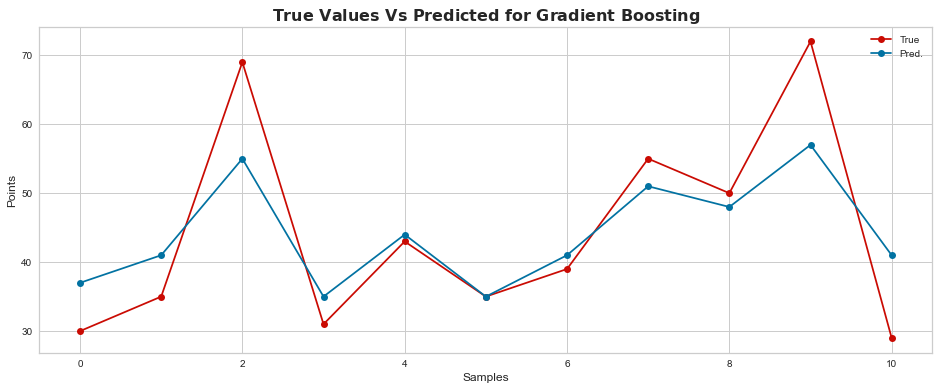

In [11]:
# Root mean squared error
def rms(y_test,y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

# Gradient Boosting Regressor
gr = GradientBoostingRegressor(criterion='mse', learning_rate=0.01,
                          max_features='sqrt', n_estimators=591,
                          random_state=1720)
gr.fit(X_train,y_train)
y_pred = np.round(gr.predict(X_test)).astype('int32')
print('R2:\t\t\t', r2_score(y_test,y_pred))
print('rmse:\t\t\t', rms(y_test,y_pred))
print('mae:\t\t\t', mean_absolute_error(y_test,y_pred))
print()
print('True values:\t\t',np.array(y_test).reshape(1,-1)[0])
print('Predicted values:\t',y_pred)
plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Gradient Boosting', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();

R2:			 0.8817525613163614
rmse:			 5.018148879997303
mae:			 4.2727272727272725

True values:		 [30 35 69 31 43 35 39 55 50 72 29]
Predicted values:	 [33 37 68 39 49 33 48 48 47 70 25]


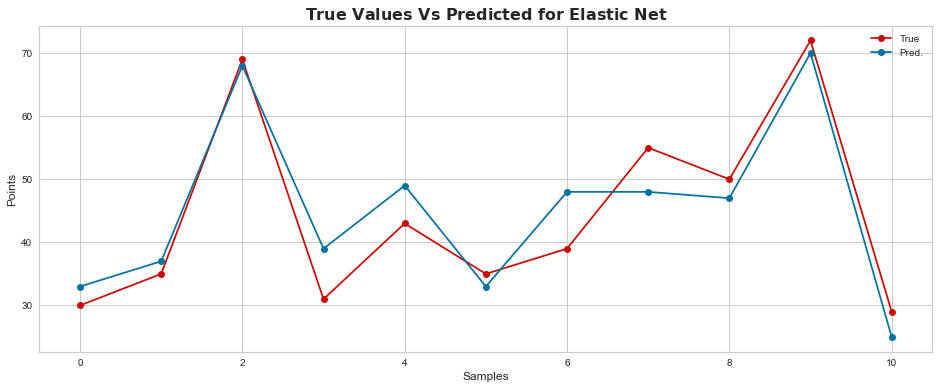

In [12]:
# Elastic Net Regressor
en = ElasticNet(alpha=0.01 ,l1_ratio=1,  normalize=True, random_state=0)
en.fit(X_train,y_train)
y_pred = np.round(en.predict(X_test)).astype('int32')
print('R2:\t\t\t', r2_score(y_test,y_pred))
print('rmse:\t\t\t', rms(y_test,y_pred))
print('mae:\t\t\t', mean_absolute_error(y_test,y_pred))
print()
print('True values:\t\t',np.array(y_test).reshape(1,-1)[0])
print('Predicted values:\t',y_pred)
plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Elastic Net', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();

R2:			 0.8518705371002794
rmse:			 5.616534033143086
mae:			 4.636363636363637

True values:		 [30 35 69 31 43 35 39 55 50 72 29]
Predicted values:	 [32 37 69 39 50 32 49 47 46 71 23]


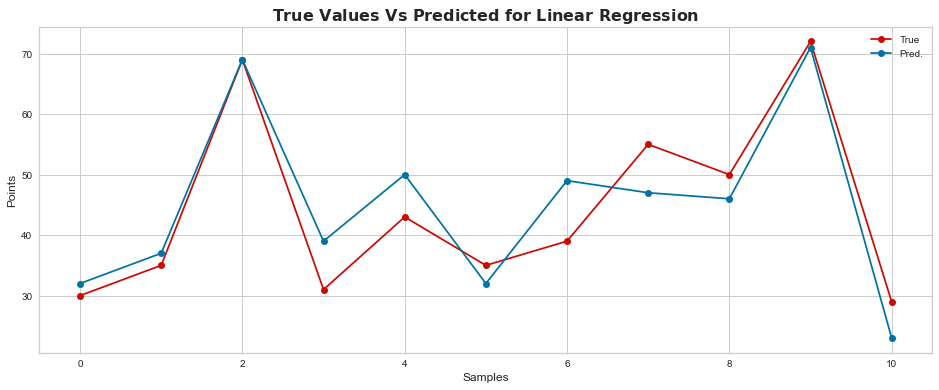

In [13]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = np.round(lr.predict(X_test)).astype('int32')
print('R2:\t\t\t', r2_score(y_test,y_pred))
print('rmse:\t\t\t', rms(y_test,y_pred))
print('mae:\t\t\t', mean_absolute_error(y_test,y_pred))
print()
print('True values:\t\t',np.array(y_test).reshape(1,-1)[0])
print('Predicted values:\t',y_pred)
plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Linear Regression', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();

#### B- Hyper-parameters Tuning For Elastic Net Model

In [14]:
# Calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

# Calculate adjusted R2 for regression
def adj_r2(r2, n, p):
    '''where n is number of samples and p is number of features'''
    return 1- ( (1-r2) * ((n-1) / (n-p-1)) )

In [15]:
parameters = {'alpha':[0, 0.01, 0.001],
             'l1_ratio':[0, 0.01, 0.001],
             'fit_intercept': [False, True],
             'max_iter': [96,97,98, 99, 100, 102, 103, 197],
             }
en = ElasticNet(random_state=1720)
reg = GridSearchCV(en, parameters,verbose=2, scoring=make_scorer(rms,greater_is_better=False), cv=5)
reg.fit(X_sc,y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96 ...........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96 ...........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96 ...........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96 ...........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96 ...........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=96, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97 ...........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=97 ..

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=102 ..........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=102 ..........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103 ..........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103 ..........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103 ..........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103 ..........
[CV]  alpha=0, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_rati

[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=100, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102 ......
[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102 ......
[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102 ......
[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102 ......
[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102 ......
[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=103 ......
[CV]  alpha=0, fit_intercept=False, l1_ratio=0.001, max_iter=103, total=   0.0s
[CV] alpha=0, 

[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102 ........
[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102 ........
[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102 ........
[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=102, total=   0.0s
[CV] alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=103 ........
[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=103 ........
[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=103 ........
[CV]  alpha=0, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0, fit_intercept=

[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102 .......
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102 .......
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102 .......
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102 .......
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=103 .......
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=103 .......
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0.01, fit_

[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96 ....
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96 ....
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96 ....
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96 ....
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=97 ....
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=97, total=   0.0s
[CV] alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=97 ....
[CV]  alpha=0.01, fit_intercept=False, l1_ratio=0.001, max_iter=97, total=   0.0s


[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99 .........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99 .........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99 .........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99 .........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=100 ........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=100, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=100 ........
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0, max_iter=100, total=   0.0s
[CV] alpha=0.01, fit_intercept=Tr

[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=97, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98 .....
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98 .....
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98 .....
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98 .....
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98 .....
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=98, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=99 .....
[CV]  alpha=0.01, fit_intercept=True, l1_ratio=0.001, max_iter=99, total=   0.0s
[CV] al

[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=100, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102 ......
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102 ......
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102 ......
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102 ......
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102 ......
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=102, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=103 ......
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0, max_iter=103, total=   0.0s
[CV] alpha=0.0

[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96 ...
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96 ...
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96 ...
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96 ...
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=96, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=97 ...
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=97, total=   0.0s
[CV] alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=97 ...
[CV]  alpha=0.001, fit_intercept=False, l1_ratio=0.001, max_iter=97, total= 

[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99 ........
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99 ........
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99 ........
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99 ........
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=99, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=100 .......
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=100, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=100 .......
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0, max_iter=100, total=   0.0s
[CV] alpha=0.001, fit_inte

[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103 ....
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103 ....
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103 ....
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103 ....
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=103, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=197 ....
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=197, total=   0.0s
[CV] alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=197 ....
[CV]  alpha=0.001, fit_intercept=True, l1_ratio=0.01, max_iter=197, total=   0.0s


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    4.9s finished


GridSearchCV(cv=5, estimator=ElasticNet(random_state=1720),
             param_grid={'alpha': [0, 0.01, 0.001],
                         'fit_intercept': [False, True],
                         'l1_ratio': [0, 0.01, 0.001],
                         'max_iter': [96, 97, 98, 99, 100, 102, 103, 197]},
             scoring=make_scorer(rms, greater_is_better=False), verbose=2)

In [16]:
print('Best estimator: ', reg.best_estimator_,'\n')
print('Best score: ', reg.best_score_ )

Best estimator:  ElasticNet(alpha=0, l1_ratio=0, max_iter=197, random_state=1720) 

Best score:  -9.215690685003235


### 1- Features Selection

####  B- Recursive Feature Elimination

In [17]:
# Get the best number of features recursively
for i in range(1,X_train.shape[1] + 1):
    print('Number of Features: ',i)

    estimator = reg.best_estimator_
    selector = RFE(estimator, n_features_to_select=i)

    selector = selector.fit(X_train, y_train)
    X_train1 = selector.transform(X_train)
    X_test1 = selector.transform(X_test)
    
    estimator.fit(X_train1, y_train)
    y_pred = np.round(estimator.predict(X_test1)).astype('int32')
    
    n = X_train1.shape[0]
    p = X_train1.shape[1]
    r2 = r2_score(y_test,y_pred)
    print('R2:\t\t\t', np.round(r2 ,3))
    print('Adj. R2:\t\t', np.round(adj_r2(r2, n, p) ,3))
    print('rmse:\t\t\t', np.round(np.sqrt(mean_squared_error(y_test,y_pred)), 3))
    print('mae:\t\t\t', np.round(mean_absolute_error(y_test,y_pred),3))
    print('BIC: \t\t\t', np.round(calculate_bic(len(y_train), mean_squared_error(y_test,y_pred), i),3))
    print('============')

Number of Features:  1
R2:			 0.042
Adj. R2:		 0.019
rmse:			 14.283
mae:			 11.091
BIC: 			 232.44
Number of Features:  2
R2:			 0.644
Adj. R2:		 0.626
rmse:			 8.713
mae:			 7.727
BIC: 			 193.692
Number of Features:  3
R2:			 0.732
Adj. R2:		 0.711
rmse:			 7.556
mae:			 6.545
BIC: 			 185.203
Number of Features:  4
R2:			 0.749
Adj. R2:		 0.723
rmse:			 7.305
mae:			 6.273
BIC: 			 186.061
Number of Features:  5
R2:			 0.74
Adj. R2:		 0.705
rmse:			 7.435
mae:			 6.0
BIC: 			 191.334
Number of Features:  6
R2:			 0.87
Adj. R2:		 0.848
rmse:			 5.266
mae:			 4.273
BIC: 			 165.431
Number of Features:  7
R2:			 0.927
Adj. R2:		 0.913
rmse:			 3.931
mae:			 3.091
BIC: 			 144.058
Number of Features:  8
R2:			 0.917
Adj. R2:		 0.897
rmse:			 4.21
mae:			 3.364
BIC: 			 153.719
Number of Features:  9
R2:			 0.926
Adj. R2:		 0.906
rmse:			 3.966
mae:			 3.182
BIC: 			 152.333
Number of Features:  10
R2:			 0.925
Adj. R2:		 0.901
rmse:			 4.0
mae:			 3.273
BIC: 			 156.833
Number of Featu

Selected features:
['Al-Ahli' 'Al-Hilal' 'Al-Ittihad' 'Al-Nassr' 'Al-Shabab' 'n_DF' 'n_S'] 

Model metrics: 
R2:	 0.9274293697609438
rmse:	 3.9312269655344823
mae:	 3.090909090909091

True values:  		 [30 35 69 31 43 35 39 55 50 72 29]
Predicted values:  	 [35 35 69 36 47 36 46 49 51 68 30]


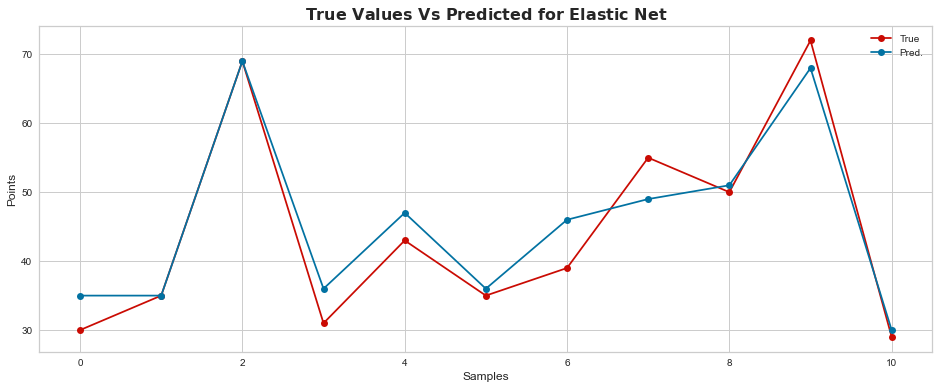

In [18]:
# Based on the model , 7 features are giving the best score
f = 7

estimator = reg.best_estimator_
selector = RFE(estimator, n_features_to_select=f)

selector = selector.fit(X_train, y_train)
X_train1 = selector.transform(X_train)
X_test1 = selector.transform(X_test)

print('Selected features:')
print(X_train.columns[selector.get_support()].values, '\n')

estimator.fit(X_train1, y_train)
y_pred = np.round(estimator.predict(X_test1)).astype('int32')

print('Model metrics: ')
print('=====================')
print('R2:\t', r2_score(y_test,y_pred))
print('rmse:\t', np.sqrt(mean_squared_error(y_test,y_pred)))
print('mae:\t', mean_absolute_error(y_test,y_pred))
print('=====================','\n')
print('True values: ','\t\t',y_test.values)
print('Predicted values: ','\t', y_pred)

plt.figure(figsize=(16,6))
plt.plot(np.array(y_test).reshape(1,-1)[0], 'ro-', label='True');
plt.plot(y_pred, 'bo-', label='Pred.');
plt.legend();
plt.grid();
plt.title('$True$ Values Vs Predicted for Elastic Net', fontsize=16)
plt.ylabel('Points', fontsize=12);
plt.xlabel('Samples', fontsize=12);
plt.grid();





In [19]:
teams_list = ['Al-Ahli','Al-Hilal','Al-Ittihad','Al-Nassr','Al-Shabab']
selected_f = X_train.columns[selector.get_support()].values
teams = X_train[selected_f]
teams.head()

,Al-Ahli,Al-Hilal,Al-Ittihad,Al-Nassr,Al-Shabab,n_DF,n_S
10,1,0,0,0,0,0.021388,0.216157
53,0,0,0,0,0,0.021388,0.216157
33,0,0,1,0,0,1.753835,0.216157
52,0,0,0,0,0,0.598871,0.515451
18,0,0,0,1,0,-1.711059,0.216157


## 4- Model Evaluation

In [20]:
# Predict next season points
def pred(team, n_df, n_s):
    """ n_df: number of defenders
        n_s: number of Saudi layers """
    team_dict = {}
    # Get the encoded vlaues for each team
    for t in teams_list:
        v = np.array(teams[teams[t] == 1].reset_index(drop=True).loc[0]).reshape(1,-1)[0]
        team_dict[t] = v[:-2]
        
    team_dict['Al-Taawoun'] = np.array([0, 0, 0, 0, 0])
    team_dict['Al-Faisaly'] = np.array([0, 0, 0, 0, 0])
    team_dict['Al-Fateh'] = np.array([0, 0, 0, 0, 0])
    team_dict['Al-Raed'] = np.array([0, 0, 0, 0, 0])
    
    temp = sc.transform(np.array([22, 22, 22, n_df, 22, n_s, 22]).reshape(1,-1))[0]
    temp = temp[3:6]
    temp = np.delete(temp, 1, 0)
    
    x_t = np.concatenate((team_dict[team],temp ), axis=0).reshape(1,-1)
    y_pred =  estimator.predict(x_t)
    y_pred = np.round(y_pred).astype('int32')[0]
    
    print('Predicted Points Next Season for {} is:'.format(team), y_pred, 'points')
    print('===============================\n')
    
    print(u"\u00B1", 3.9, 'points for 68%')
    print('The Range of Predicted Points for {} is:'.format(team), round(y_pred - 3.9), 'and', round(y_pred + 3.9),
         'points')
    print('===============================\n')
    print(u"\u00B1", 7.8, 'points for 95%')
    print('The Range of Predicted Points for {} is:'.format(team), round(y_pred - 7.8), 'and', round(y_pred + 7.8),
         'points')

In [21]:
# ['Al-Hilal', 'Al-Nassr', 'Al-Ahli', 'Al-Taawoun', 'Al-Shabab','Al-Ittihad', 'Al-Faisaly', 'Al-Raed', 'Al-Fateh']

# pred(Team, no of DF players, no of Saudi players)
pred('Al-Shabab', 4, 25)

Predicted Points Next Season for Al-Shabab is: 52 points

± 3.9 points for 68%
The Range of Predicted Points for Al-Shabab is: 48.0 and 56.0 points

± 7.8 points for 95%
The Range of Predicted Points for Al-Shabab is: 44.0 and 60.0 points


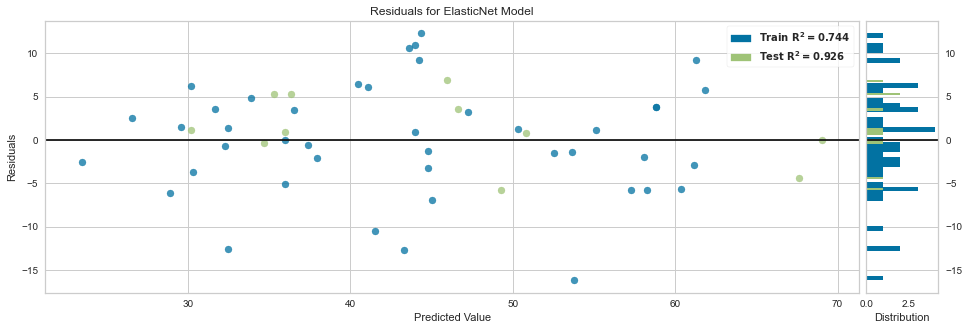

In [22]:
plt.figure(figsize=(16,5));
visualizer = ResidualsPlot(estimator)
visualizer.fit(X_train1, y_train);
visualizer.score(X_test1, y_test);
visualizer.show();